In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import defaultdict

SEED = 1
torch.random.manual_seed(SEED)
np.random.seed(SEED)

# Atomic Experiments

## Node2Vec

In order to gain better insight on Node2Vec let's design an atomic experiment. 

Suppose that we have the following graph




![](../figures/graph.png)

and we would like to create the Node2Vec embedding. Try answering the following questions before running the code:

1. What is a good choice for the embedding dimension?
2. What do you expect to find in the vector representations?
3. How long do you expect this to take training? why?
4. What is a good window size?
5. How do you think the weights A, B, C, and D affect the results?

### A math question:

- How to transform weights into probabilities?

# Creating the embeddings

We need to do several things:

0. Imports, seeds
1. Create a way of representing the graph and the weights.
2. Create the random walks.
3. Use the word2vec embeddings. 

# 0. Preparations

We import the needed packages and set the random seeds.

## 1. Encoding the Graph

There are many ways of encoding a graph. We will use a simple way where we keep a dictionary of current nodes to the nodes that it reaches and their corresponding weights.

In [2]:
def create_graph(A: int=1, B: int=2, C: int=3, D: int=4) -> dict:
    '''
    Function that generates graph of figure above based on weights. Graph captured as a dictionary 
    In the graph shown above:
    Yellow = Y
    Blue = B
    Green = G
    Red = R
    Soft Yellow = SY
    Soft Blue = SB
    Soft Green = SG
    '''
    
    graph = {}
    graph["G"] = {"B": A, "Y": C}
    graph["B"] = {"G": A, "Y": B}
    graph["Y"] = {"B": B, "G": C, "R":D}
    
    graph["R"] = {"Y": D, "SY": D}
    
    graph["SG"] = {"SB": A, "SY": C}
    graph["SB"] = {"SG": A, "SY": B}
    graph["SY"] = {"SB": B, "SG": C, "R":D}
    
    return graph

In [3]:
graph = create_graph()

## 2. Creating the random walks

We need to create a large collection of walks. We will leave the number of steps and the number of samples as parameters.

In [4]:
# Returns what node to go next
def next_node(graph: dict, node: str) -> str:
    """
    Function that takes a graph in the form of a dictionary and a node and returns what node to go next
    args:
        graph : dictionary capturing:
            keys - nodes 
            values - dictionary of next node to move to and corresponding weight
        node : string capturing current node where the walker is located
    returns: string captring what node to go next from current node
    """
    
    # ===== Write your code here (HARD) ========
    neighbors = graph[node]
    
    n = []
    dist = []
    total = 0
    for key, val in neighbors.items():
        n.append(key)
        dist.append(val)
        total += val
    
    dist = [p/total for p in dist]
    # =========================================== 
    
    return np.random.choice(n,1,p=dist)[0]
    

def walk_from_node(graph: dict, node: str, steps: int=5) -> list:
    """
    Function that returns a random walk as a list based on a starting node and the whole graph given as a dictionary
    args:
        graph : dictionary capturing:
            keys - nodes 
            values - dictionary of next node to move to and corresponding weight
        node : string capturing current node where the walker is located
        steps : integer representing number of steps the walker will take before it stops at the end node
    returns: walk - random walk in the form of a list
        
    """
    
    walk = []
    
    # =========== Write your code here ===========
    for step in range(steps):
        walk.append(node)
        node = next_node(graph, node)
    # ===========================================    
    
    return walk


def create_random_walks(graph: dict, walker_steps: int=5, num_walkers: int=3) -> list:
    """
    Function that generates a list of random walks. Each random walk in the list is a list in itself
    args:
        graph : dictionary capturing:
            keys - nodes 
            values - dictionary of next node to move to and corresponding weight
        walker_steps : integer representing number of steps each walker in the list of walkes will take before it stops
                    this is also the length of each walker in the list of walkers
        num_walkers : integer representing the number of walkers to be generated
        
    returns: walks_list - list of random walkers
    """
    
    walks_list = []
    
    # =========== Write your code here ===========
    for _ in range(num_walkers):
        for node in ["G", "B", "Y", "R", "SG", "SB", "SY"]:
            walks_list.append(walk_from_node(graph, node, walker_steps))
    # ===========================================        
    
    return walks_list

We can get some example with the next line

In [5]:
sentences = create_random_walks(graph, 10, 100)
sentences[:10]

[['G', 'Y', 'R', 'Y', 'G', 'B', 'G', 'B', 'Y', 'G'],
 ['B', 'Y', 'R', 'Y', 'R', 'Y', 'R', 'Y', 'R', 'Y'],
 ['Y', 'R', 'SY', 'SG', 'SY', 'R', 'SY', 'SB', 'SG', 'SB'],
 ['R', 'Y', 'G', 'Y', 'G', 'Y', 'G', 'Y', 'R', 'Y'],
 ['SG', 'SY', 'R', 'Y', 'R', 'Y', 'G', 'Y', 'G', 'Y'],
 ['SB', 'SG', 'SY', 'SB', 'SG', 'SY', 'SB', 'SY', 'SB', 'SY'],
 ['SY', 'SB', 'SY', 'R', 'Y', 'B', 'Y', 'R', 'SY', 'R'],
 ['G', 'Y', 'B', 'G', 'Y', 'G', 'B', 'Y', 'G', 'Y'],
 ['B', 'Y', 'R', 'SY', 'SG', 'SY', 'R', 'Y', 'R', 'SY'],
 ['Y', 'B', 'Y', 'G', 'Y', 'G', 'B', 'Y', 'R', 'Y']]

## 3. Creating the Embedings
Now that we have the "sentences" we need to transform them into numerical labels that represent the one-hot encoding.

In [6]:
node2idx = {"G": 0, "B": 1, "Y":2, "R":3, "SG":4, "SB":5, "SY":6}
# geneate idx2node programmatically 
idx2node = dict((v,k) for k,v in node2idx.items())

In [7]:
node2idx

{'G': 0, 'B': 1, 'Y': 2, 'R': 3, 'SG': 4, 'SB': 5, 'SY': 6}

In [8]:
idx2node

{0: 'G', 1: 'B', 2: 'Y', 3: 'R', 4: 'SG', 5: 'SB', 6: 'SY'}

Next we create the skip-gram model. First the pairs

In [9]:
def create_pairs(sentence: list, window: int) -> list:
    """
    Function that returns a list of pairs. Each pair is a list in itself represents the indices resulting from
    the skip-gram approach for word2vec
    args:
         sentence: list capturing the "sentences" generated by the random walkers
         window: integer used in the skip-gram method - it is the maximum context location at which the words
                  need to be predicted
    returns: list of pairs the indices resulting from the skip-gram approach for word2vec
    """
    
    assert window>0, "The window size should be greater than 0"
    pairs_list = []
    
    # =========== Write your code here ===========
    l = len(sentence)
    for i in range(l):
        for j in range(max(i-window,0), min(i+window+1, l)):
            if i!=j:
                pairs_list.append([sentence[i], sentence[j]])
    # ===========================================     
    
    return pairs_list

We can use this to generate our data

In [10]:
data = []
for sentence in sentences:
    pair_ = create_pairs([node2idx[node] for node in sentence], 1)
    data += pair_

In [11]:
data[:5]

[[0, 2], [2, 0], [2, 3], [3, 2], [3, 2]]

and then create our embeddings. 

In [12]:
emb_center = torch.nn.Embedding(7,3)
emb_context = torch.nn.Embedding(7,3)

We do the training in a particular way to introduce the concept of schedule learning rate. 

In [13]:
losses = []

learning_rates = {'schedule_1': 0.1, 'schedule_2': 0.01, 'schedule_3': 0.001, 'schedule_4': 0.00001}

print("Using Learning rate of ", learning_rates['schedule_1'])
for pair in data:
    a, b = pair
    emb_center.zero_grad()
    emb_context.zero_grad()
    a_against_all = torch.matmul(
        emb_context(torch.tensor([0, 1, 2, 3, 4, 5, 6])),
        emb_center(torch.tensor([a])).transpose(0,1))
    result = torch.nn.functional.log_softmax(a_against_all, dim=0)
    loss = torch.nn.functional.nll_loss(
        result.view(1, -1), torch.tensor([b]))
    loss.backward()

    losses.append(loss.item())
    for param in emb_center.parameters():
         param.data -= learning_rates['schedule_1']*param.grad
    for param in emb_context.parameters():
         param.data -= learning_rates['schedule_1']*param.grad

print("Using Learning rate of ", learning_rates['schedule_2'])
for pair in data:
    a, b = pair
    emb_center.zero_grad()
    emb_context.zero_grad()
    a_against_all = torch.matmul(
        emb_context(torch.tensor([0, 1, 2, 3, 4, 5, 6])),
        emb_center(torch.tensor([a])).transpose(0,1))
    result = torch.nn.functional.log_softmax(a_against_all, dim=0)
    loss = torch.nn.functional.nll_loss(
        result.view(1, -1), torch.tensor([b]))
    loss.backward()

    losses.append(loss.item())
    for param in emb_center.parameters():
         param.data -= learning_rates['schedule_2']*param.grad
    for param in emb_context.parameters():
         param.data -= learning_rates['schedule_2']*param.grad

            
print("Using Learning rate of ", learning_rates['schedule_3'])
for pair in data:
    a, b = pair
    emb_center.zero_grad()
    emb_context.zero_grad()
    a_against_all = torch.matmul(
        emb_context(torch.tensor([0, 1, 2, 3, 4, 5, 6])),
        emb_center(torch.tensor([a])).transpose(0,1))
    result = torch.nn.functional.log_softmax(a_against_all, dim=0)
    loss = torch.nn.functional.nll_loss(
        result.view(1, -1), torch.tensor([b]))
    loss.backward()

    losses.append(loss.item())
    for param in emb_center.parameters():
         param.data -= learning_rates['schedule_3']*param.grad
    for param in emb_context.parameters():
         param.data -= learning_rates['schedule_3']*param.grad

print("Using Learning rate of ", learning_rates['schedule_4'])
for pair in data:
    a, b = pair
    emb_center.zero_grad()
    emb_context.zero_grad()
    a_against_all = torch.matmul(
        emb_context(torch.tensor([0, 1, 2, 3, 4, 5, 6])),
        emb_center(torch.tensor([a])).transpose(0,1))
    result = torch.nn.functional.log_softmax(a_against_all, dim=0)
    loss = torch.nn.functional.nll_loss(
        result.view(1, -1), torch.tensor([b]))
    loss.backward()

    # print(a,b,"\n",result, result[b])
    losses.append(loss.item())
    for param in emb_center.parameters():
         param.data -= learning_rates['schedule_4']*param.grad
    for param in emb_context.parameters():
         param.data -= learning_rates['schedule_4']*param.grad


Using Learning rate of  0.1
Using Learning rate of  0.01
Using Learning rate of  0.001
Using Learning rate of  1e-05


Let's take a look at the losses

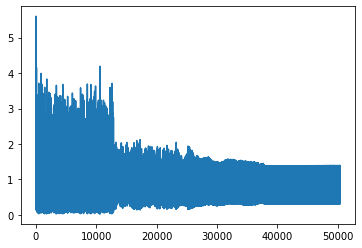

In [14]:
# Note: this code is not working properly
plt.plot(losses)
plt.show()

and the resulting probability distributions

In [15]:
prob_dist = torch.nn.functional.softmax(
    torch.matmul( emb_context(torch.tensor([0,1,2,3,4,5,6])),
                 emb_center(torch.tensor([0,1,2,3,4,5,6])).transpose(0,1)),
    dim = 0)
(1000*prob_dist).round()/1000

tensor([[0.0050, 0.3160, 0.3240, 0.0010, 0.0000, 0.0010, 0.0020],
        [0.2640, 0.0060, 0.2530, 0.0010, 0.0000, 0.0000, 0.0010],
        [0.7280, 0.6740, 0.0010, 0.5210, 0.0030, 0.0030, 0.0000],
        [0.0000, 0.0000, 0.4190, 0.0000, 0.0000, 0.0000, 0.4200],
        [0.0000, 0.0010, 0.0020, 0.0010, 0.0060, 0.3500, 0.3260],
        [0.0000, 0.0000, 0.0010, 0.0010, 0.2920, 0.0060, 0.2490],
        [0.0020, 0.0030, 0.0000, 0.4760, 0.6990, 0.6390, 0.0020]],
       grad_fn=<DivBackward0>)

and in order to run some experiments let's get the individual vector representations

In [16]:
[G, B, Y, R, SG, SB, SY] = emb_center.weight
emb_center.weight

Parameter containing:
tensor([[-1.9218,  1.6399,  0.3617],
        [-0.7324, -0.4179,  2.4045],
        [-1.5934, -1.3765, -0.4126],
        [ 0.4154,  1.6028,  1.3406],
        [ 1.2257,  1.9169, -1.0491],
        [ 2.2683, -0.1371,  1.0720],
        [ 0.9944, -1.1212, -1.5599]], requires_grad=True)

## Analogies

It is clear from the graph that there are cluster that are similar, we could think of them as analogies. We need something else first. 

### Finding the closest one

We need to a function to find the closest point (in cosine distance) to a given one

In [17]:
def cosine_distance(a: torch.Tensor, b: torch.Tensor) -> float:
    """
    Function that computes the cosine distance between two tensors
    args: a, b - tensors
    returns: cosine distance 
    """
    
    # =========== Write your code here ===========
    d = 1-torch.mul(a,b).sum()/torch.sqrt(torch.mul(a,a).sum() * torch.mul(b,b).sum())
    # ============================================
    
    return d

def closest(a: torch.Tensor) -> tuple:
    """
    Function that, based on a node embeding, returns tuple capuring the string with the closest node and distance to
    closest node
    
    """
    
    min_distance = float("inf")
    mini_at = None 
    
    # =========== Write your code here ===========
    for node, label in node2idx.items():
        if cosine_distance(a, emb_center.weight[label]) < min_distance:
            min_distance = cosine_distance(a, emb_center.weight[label])
            mini_at = node
    # ============================================
    
    return mini_at, min_distance

we can check that this is well defined if the following returns (Y,0)

In [18]:
closest(Y)

('Y', tensor(0., grad_fn=<RsubBackward1>))

### Some analogies

Let's see if we can get some analogies.

In [19]:
closest(SB-B+G)

('SG', tensor(0.0015, grad_fn=<RsubBackward1>))

In [20]:
closest(SG-G+B)

('SB', tensor(0.0013, grad_fn=<RsubBackward1>))

In [21]:
closest(SY-Y+G)

('SG', tensor(0.0242, grad_fn=<RsubBackward1>))

# Some Remarks/Questions

## From counts to probability distributions

We can get the expected results by a simple count as we did in our previous experiment. Make sure that you understand how the following relates to the results


In [22]:
counts = defaultdict(int)
for d in data:
    counts[tuple(d)]+=1
counts

defaultdict(int,
            {(0, 2): 959,
             (2, 0): 959,
             (2, 3): 1243,
             (3, 2): 1243,
             (0, 1): 353,
             (1, 0): 353,
             (1, 2): 686,
             (2, 1): 686,
             (3, 6): 1194,
             (6, 3): 1194,
             (6, 4): 892,
             (4, 6): 892,
             (6, 5): 628,
             (5, 6): 628,
             (5, 4): 345,
             (4, 5): 345})

## Embedding dimension 

The embedding dimension here is a tricky business. Try to use dim = 2 and see what happens? Can you get the analogy results? (Hard) Why do you think that happens? 

## Different seeds

What happens if we change the random seed to 13, or 42. Do we get the same results? what conclusions can you gather about this?

## Loss function

Look at the loss function. Make sure that you understand why the LR change creates a decrease in the loss. Can you ever get a loss of zero? why?